# Segmentation of cell images
## Project 9

In [1]:
import numpy as np
import os
import torch
import time
import matplotlib.pyplot as plt
from skimage import io, transform
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from os import listdir
from os.path import splitext
from glob import glob
from natsort import natsorted
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise, Rotate, ElasticTransform )
from albumentations.pytorch import ToTensor
import shutil
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
## Hyper parameters
slowPC = False
val_percent=0.12
batch_size=2
epochs=500
learning_rate=0.0005

if slowPC:
    dir_img = 'data/small/img/'
    dir_mask = 'data/small/mask/'
else:
    dir_img = 'data/train/img/'
    dir_mask = 'data/train/mask/'
    
dir_checkpoint = 'checkpoint/latest/checkpoint.pt'
dir_best_model = 'checkpoint/best/500EpochModelConvTranspose2dManyDrops.pt'

## 1. Loading and normalizing the Gland dataset

Load the data using a custom dataloader from pytorch, and do some preprocessing.

In [3]:
def get_transforms():
            list_transforms = []
            
            list_transforms.extend(
                    [
                HorizontalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                    ])
            list_transforms.extend(
                    [
            ToTensor(),
                    ])
            list_trfms = Compose(list_transforms)
            return list_trfms

def standardize(img, mean, std):
        img = (img - mean) / std
        return img


class cellData(Dataset):
    """Gland dataset."""
    def __init__(self, imgs_dir, masks_dir):
        
        img_name_list = [splitext(file)[0] for file in listdir(imgs_dir) if not file.startswith('.')]

        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.ids = natsorted(img_name_list)
        red = []
        redSD = []
        blue= []
        blueSD = []
        green = []
        greenSD = []

        for idx in self.ids:
            img_file = glob(self.imgs_dir + idx + '.*')
            img = io.imread(img_file[0])[:,:,:].astype('float32')
            red.append(np.mean(img[:,:,0]))
            redSD.append(np.std(img[:,:,0]))
            green.append(np.mean(img[:,:,1]))
            greenSD.append(np.std(img[:,:,1]))
            blue.append(np.mean(img[:,:,2]))
            blueSD.append(np.std(img[:,:,2]))
    
        self.red_mean = np.mean(red)
        self.red_sd = np.mean(redSD)
        
        self.blue_mean = np.mean(blue)
        self.blue_sd = np.mean(blueSD)
        
        self.green_mean = np.mean(green)
        self.green_sd = np.mean(greenSD)
        
        self.transform = get_transforms()
            

    def __len__(self):
        return len(self.ids)
            

    def __getitem__(self,i):
        idx = self.ids[i]

        found_img_files = glob(self.imgs_dir + idx + '.*')
        img_name = found_img_files[0]
        img = io.imread(img_name).astype('float32')
        img = transform.resize(img,(512,512))
        r_channel = standardize(img[:,:,0], self.red_mean, self.red_sd)
        g_channel = standardize(img[:,:,1], self.green_mean, self.green_sd)
        b_channel = standardize(img[:,:,2], self.blue_mean, self.blue_sd)
        img = np.stack([r_channel, g_channel, b_channel], axis=-1)

        found_mask_files = glob(self.masks_dir + idx + '_anno.*')
        mask_name = found_mask_files[0]
        mask = self.get_mask(mask_name, 512, 512).astype('float32')


        ## Do tranformations.         
        augmented = self.transform(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        mask = mask[0].permute(2, 0, 1)
        
        return (img, torch.round(mask))


    def get_mask(self,mask_file,IMG_HEIGHT, IMG_WIDTH):
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        mask_ = io.imread(mask_file)
        mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
        mask_ = np.expand_dims(mask_,axis=-1)
        mask = np.maximum(mask, mask_)
        
        return mask


            

In [4]:
# Loading the data
data = cellData(imgs_dir=dir_img, masks_dir=dir_mask)

# Checking the shape of the images and masks 
print("Number of traning images: " + str(len(data)))

for img,msk in data:
    print("Image shape: " + str(img.shape))
    print("Mask shape: " + str(msk.shape))
    break


Number of traning images: 85
Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([1, 512, 512])


In [5]:
# Splitting the dataset into train and validation

n_val = int(len(data) * val_percent)
n_train = len(data) - n_val
train, val = random_split(data, [n_train, n_val])

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)

train_data_iter = iter(train_loader)
val_data_iter = iter(val_loader)


In [6]:
# converting image tensor to numpy array
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0)) 
    std = np.array((data.red_sd, data.green_sd, data.blue_sd))
    mean = np.array((data.red_mean, data.green_mean, data.blue_mean))
    image  = (std * image + mean)
    image = (image).astype(np.uint8)
    return image

# converting mask tensor to numpy array
def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

In [7]:
## Visualisation of original images and actual masks

def plot_img(no):
    if no > len(images):
        print("The batch does only contain {} images.".format(len(images)))
        no = len(images)
    
    plt.figure(figsize=(15,15))
    
    for idx in range(0,no):
          image = image_convert(images[idx])
          plt.subplot(2,no,idx+1)
          plt.title('image')
          plt.imshow(image)
    for idx in range(0,no):
          mask = mask_convert(masks[idx])
          plt.subplot(2,no,idx+no+1)
          plt.title('mask')
          plt.imshow(mask,cmap='gray')
    plt.show()


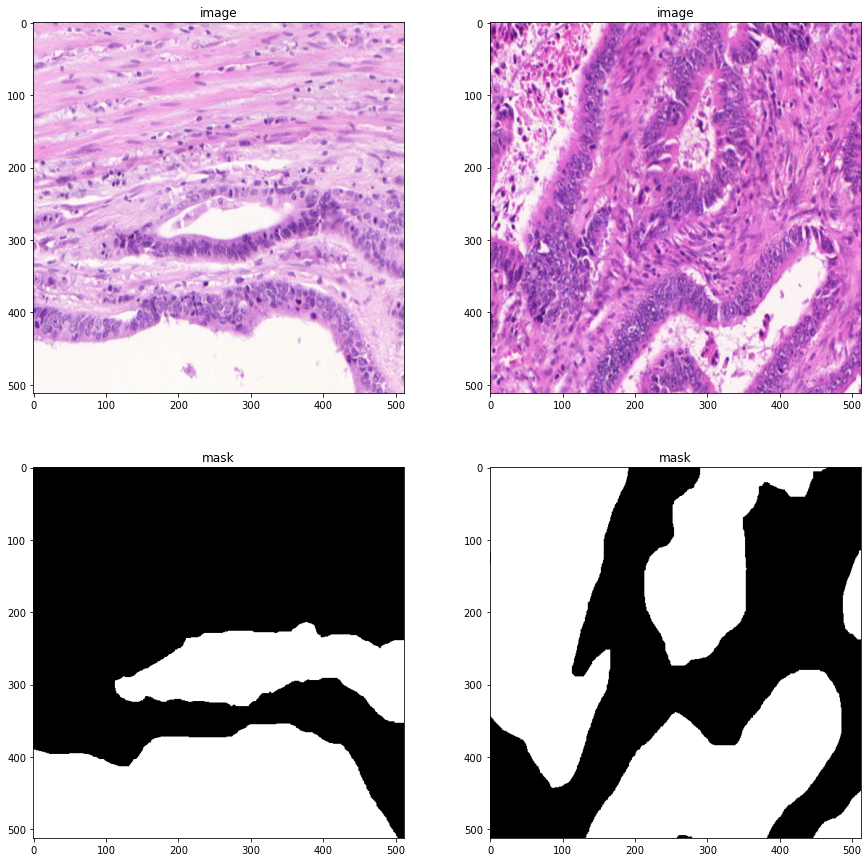

In [8]:
# get the images and mask in the first batch. 
images, masks = next(train_data_iter)
#print(image_convert(images[0]))

# Show images and masks
plot_img(2)

## 2. Deffining the Unet structure

In [9]:
# Unet using 'ConvTranspose2d' but only 4 down and 3 up. 

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5)
    )

class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dblock1 = double_conv(3, 64)
        self.dblock2 = double_conv(64, 128)
        self.dblock3 = double_conv(128,256)
        self.dblock4 = double_conv(256,512)

        self.up1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.ublock1 = double_conv(512,256)

        self.up2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.ublock2 = double_conv(256,128)

        self.up3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.ublock3 = double_conv(128,64)

        self.last_layer = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()

    def forward(self,image):
        # Encoder
        x1 = self.dblock1(image)
        x2 = self.max_pool(x1)

        x3 = self.dblock2(x2)
        x4 = self.max_pool(x3)

        x5 = self.dblock3(x4)
        x6 = self.max_pool(x5)

        x7 = self.dblock4(x6)
        

        # Decoder
        x = self.up1(x7)
        x = self.ublock1(torch.cat([x, x5], dim=1))

        x = self.up2(x)
        x = self.ublock2(torch.cat([x, x3], dim=1))

        x = self.up3(x)
        x = self.ublock3(torch.cat([x, x1], dim=1))


        out = self.last_layer(x)
        return out

## 3. Traning the model

In [10]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
    
## IOU computation
def iou_(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou



def iou_batch(y_pred,y):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    y_pred = F.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy() 
    
    for pred, label in zip(y_pred, y):
        ious.append(iou_(pred, label))
    iou = np.nanmean(ious)
    return iou    

In [11]:
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Unet().to(device)


# Specifying the optimizer and the cost function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
valid_loss_min = 10 # This is for the checkpoint
criterion = DiceBCELoss()



epoch = 0
loadCheckpoint = False
# Load the latest checkpoint
if loadCheckpoint:
    checkpoint = torch.load(dir_checkpoint)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    valid_loss_min = checkpoint['valid_loss_min']
    model.train()

    
print("Starting traning: \n",
    "Epochs:          \t{}\n".format(epochs),
    "Batch size:      \t{}\n".format(batch_size),
    "Learning rate:   \t{}\n".format(learning_rate),
    "Training size:   \t{}\n".format(n_train),
    "Validation size: \t{}\n".format(n_val),
    "Device:          \t{}\n".format(device.type))
    


model.train()
train_loss,val_loss = [],[]
train_iou,val_iou = [],[]

for epoch in range(epoch, epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()
    
    
    running_train_loss = []
    running_train_score = []
    counter = 0
    for image,mask in train_loader: 
           # counter = counter+1
           # print(counter)

            image = image.to(device,dtype=torch.float)
            mask = mask.to(device,dtype=torch.float)
            
            pred_mask = model.forward(image) # forward propogation
            loss = criterion(pred_mask,mask)
            score = iou_batch(pred_mask,mask)
            optimizer.zero_grad() # setting gradient to zero
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())
            running_train_score.append(score)


    running_val_loss = []
    running_val_score = []
    model.eval()
    with torch.no_grad():
        for image,mask in val_loader:
                image = image.to(device,dtype=torch.float)
                mask = mask.to(device,dtype=torch.float)                            
                pred_mask = model.forward(image)
                loss = criterion(pred_mask,mask)
                score = iou_batch(pred_mask,mask)
                running_val_loss.append(loss.item())
                running_val_score.append(score)

    model.train()


    epoch_train_loss,epoch_train_score = np.mean(running_train_loss) ,np.mean(running_train_score)
    print('Train loss : {} iou : {}'.format(epoch_train_loss,epoch_train_score))                       
    train_loss.append(epoch_train_loss)
    train_iou.append(epoch_train_score)

    epoch_val_loss,epoch_val_score = np.mean(running_val_loss),np.mean(running_val_score)
    print('Validation loss : {} iou : {}'.format(epoch_val_loss,epoch_val_score))                                
    val_loss.append(epoch_val_loss)
    val_iou.append(epoch_val_score)


    # Create a checkpoint
    torch.save({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'valid_loss_min': epoch_val_loss,
        }, dir_checkpoint)
    
    
    # If the state of the checkpoint is the best model yet
 #   if epoch_val_loss <= valid_loss_min:
 #       print ("Found a new best model, saving it.")
 #       shutil.copyfile(dir_checkpoint, dir_best_model)
 #       valid_loss_min = epoch_val_loss
        
    # Print the time for completing the epoch
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    


9/500
Train loss : 0.1517814837004009 iou : 0.8135670887962736
Validation loss : 0.6397023618221283 iou : 0.3810304984593253
0m 35s
Epoch 360/500
Train loss : 0.14175867563799807 iou : 0.8229345034430933
Validation loss : 0.48815897703170774 iou : 0.48786152548018213
0m 35s
Epoch 361/500
Train loss : 0.13770991152054385 iou : 0.8284754008603121
Validation loss : 0.28387675285339353 iou : 0.6443383147716273
0m 35s
Epoch 362/500
Train loss : 0.14441072607510969 iou : 0.8177358916091557
Validation loss : 0.6888080298900604 iou : 0.3326437361730578
0m 35s
Epoch 363/500
Train loss : 0.137980724831945 iou : 0.8284618244167529
Validation loss : 0.4987181454896927 iou : 0.49560322468737394
0m 35s
Epoch 364/500
Train loss : 0.13818580010219625 iou : 0.8275561824066109
Validation loss : 0.29354509711265564 iou : 0.599406290558571
0m 35s
Epoch 365/500
Train loss : 0.13493264525344498 iou : 0.8319695335282082
Validation loss : 0.2504361540079117 iou : 0.66287411008086
0m 35s
Epoch 366/500
Train lo

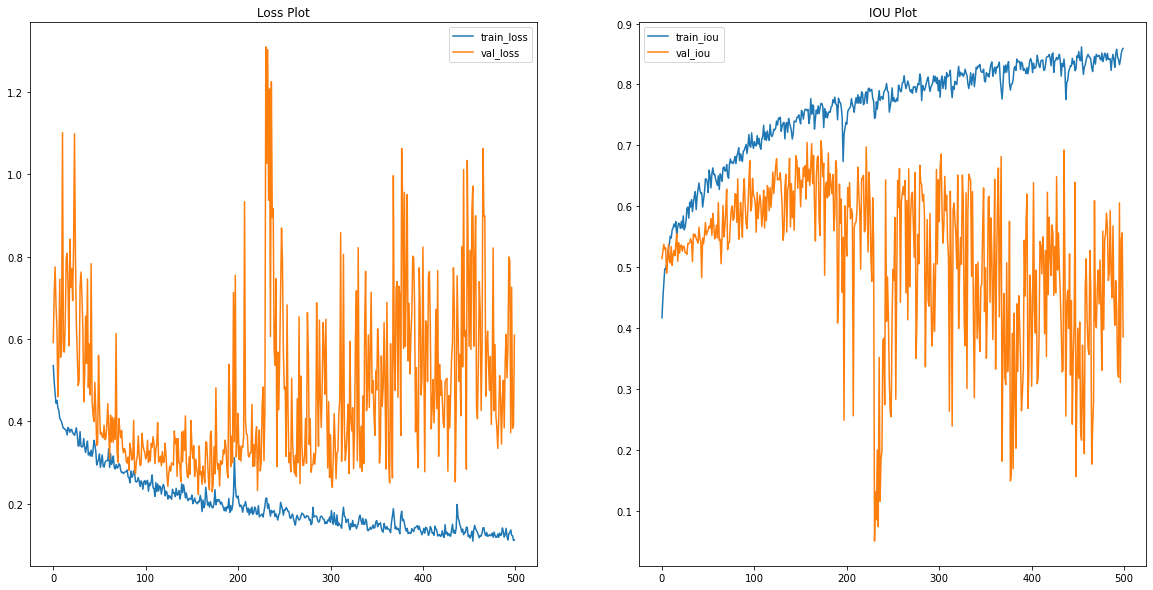

In [12]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(train_iou,label='train_iou')
plt.plot(val_iou,label='val_iou')
plt.legend()
plt.title('IOU Plot')
plt.show()

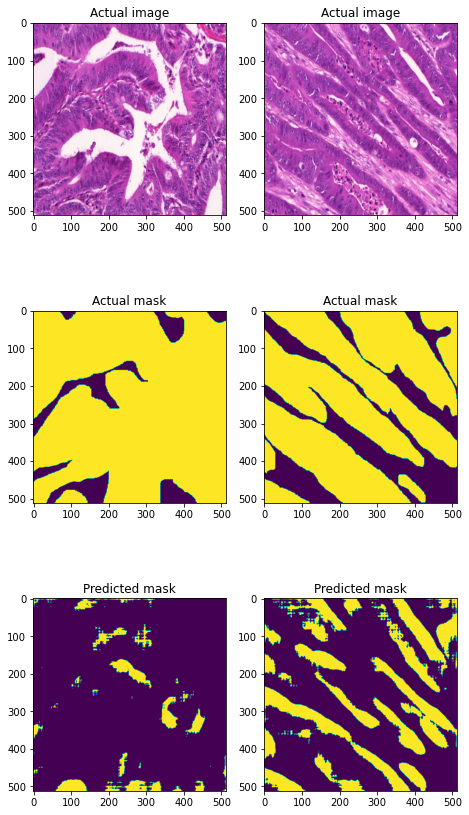

In [13]:
model.eval()
iter_ = iter(val_loader)
image,mask = next(iter_)
image = image.to(device,dtype=torch.float)
mask = mask.to(device,dtype=torch.float)
y_pred = model.forward(image)


plt.figure(figsize=(20,15))
for i in range(0,len(image)):
    plt.subplot(3,5,i+1)
    plt.title('Actual image')
    plt.imshow(image_convert(image[i])) 
for i in range(0,len(image)):
    plt.subplot(3,5,i+5+1)
    plt.title('Actual mask')
    plt.imshow(mask_convert(mask[i]))
for i in range(0,len(image)):
    plt.subplot(3,5,i+10+1)
    plt.title('Predicted mask')
    plt.imshow(mask_convert(torch.round(y_pred[i])))
plt.show()



In [14]:
if True:
    shutil.copyfile(dir_checkpoint, dir_best_model)